# Preditor de tipos de vinho

## a) Considerando o conjunto de dados Wine Dataset da UCI,

1.Explore visualmente e numericamente os dados.

2.Prepare os dados utilizando as técnicas ensinadas na disciplina, quando pertinente.

3.Para cada técnica de preparação de dados aplicada, avalie os algorimos K-NN, LogisticRegression, SVM, Árvore de descisão, RandomForest e um outro que deverá ser escolhido pelo aluno.

4.Utilize gráficos e tabelas para apresentar as métricas obtidas (em treino e em teste), e escolha o melhor modelo com base em uma das métricas apresentadas. Justifique a escolha da métrica com base no sistema em questão.

5.Envie a URL do jupyter notebook no GitHub.

# Setup do projeto

In [1]:
import joblib
import os
import urllib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

print('Matplot version: {}'.format(matplotlib.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
print('Seaborn version: {}'.format(sns.__version__))


WINE_ROOT = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/'
WINE_URL = WINE_ROOT + 'wine.data'

DATA_PATH = os.path.join('..','data', 'raw')
DATA_FILE = 'wine.csv'
WINE_DATA = os.path.join(DATA_PATH, DATA_FILE)

RANDOM_STATE = 42

Matplot version: 3.1.3
Numpy version: 1.18.1
Pandas version: 1.0.1
sklearn version: 0.22.1
Seaborn version: 0.10.0


# Recuperação dos dados

In [2]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)


In [3]:
download_data(WINE_URL, DATA_PATH, DATA_FILE)

In [4]:
def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header = None, names=['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                                                         'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                                                         'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                                                         'Proline'])

In [5]:
wine_data = load_data(DATA_PATH, DATA_FILE)

# 1.Explore visualmente e numericamente os dados.

In [6]:
wine_data.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


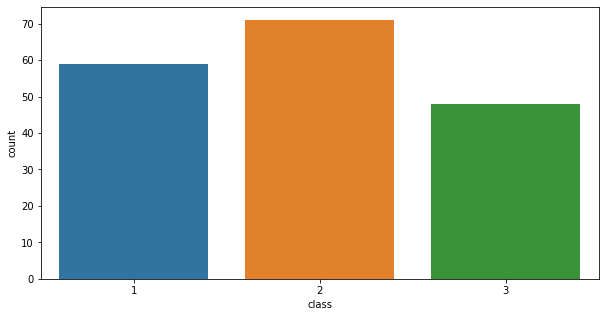

In [7]:
plt.figure(figsize=(10,5))
_= sns.countplot(x='class', data=wine_data)

In [8]:
wine_data['class'].value_counts()

2    71
1    59
3    48
Name: class, dtype: int64

In [9]:
#wine_data['class'] = wine_data['class'].astype(str)

## Verificando valores nulos (NA)

In [10]:
wine_data.describe()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


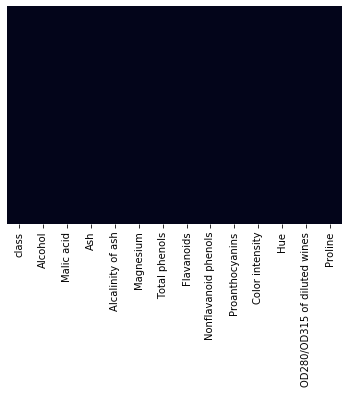

In [11]:
_= sns.heatmap(wine_data.isnull(), yticklabels = False, cbar=False)

## Correlação e distribuição

In [12]:
x = wine_data[['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
               'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
               'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
               'Proline']]
y = wine_data['class']

In [13]:
x.shape

(178, 13)

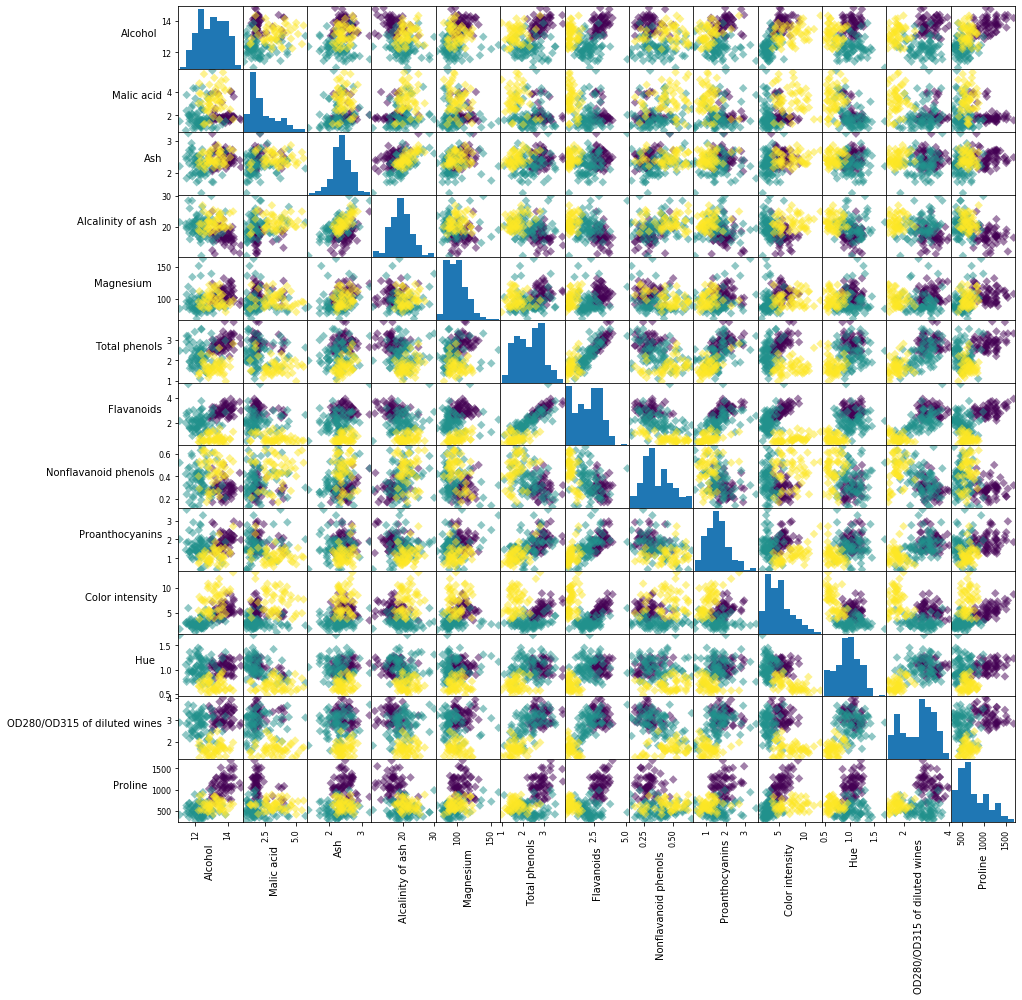

In [14]:
cores = y.astype('category').cat.codes
axes = pd.plotting.scatter_matrix(x, c=cores, figsize=[15,15], marker='D')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

# 2.Prepare os dados utilizando as técnicas ensinadas na disciplina, quando pertinente.

In [15]:
x = wine_data.drop(['class'], axis = 1)
y = wine_data['class']

min_max_scaler = MinMaxScaler()
X_scaled_mm = pd.DataFrame(min_max_scaler.fit_transform(x))
X_scaled_mm.columns = x.columns

scaler = StandardScaler()
X_st_scaled = pd.DataFrame(scaler.fit_transform(x))
X_st_scaled.columns = x.columns

In [16]:
x.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [17]:
X_scaled_mm.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


In [18]:
X_st_scaled.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


# 3.Para cada técnica de preparação de dados aplicada, avalie os algorimos K-NN, LogisticRegression, SVM, Árvore de descisão, RandomForest e um outro que deverá ser escolhido pelo aluno.

## Particionamento do dataset

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size=.3, random_state=RANDOM_STATE)
x_train_mm, x_test_mm, y_train_mm, y_test_mm = train_test_split(X_scaled_mm, y, stratify = y, test_size=.3, random_state=RANDOM_STATE)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(X_st_scaled, y, stratify = y, test_size=.3, random_state=RANDOM_STATE)

## Treinamento e teste do Modelo

In [20]:
def build_classifiers():
    """Retorna uma lista com os classificadores que serão avaliados"""
    
    classifiers = []
    classifiers.append(
        ('knn',                            # nome do classificador
         KNeighborsClassifier(),           # instancia do classificador
         {'n_neighbors': range(1, 33, 2)}  # hyperparametros
        )
    )

    classifiers.append(
        ('lr',                                               # nome do classificador
        LogisticRegression(max_iter=100),                               # instancia do classificador
         {'penalty': ['l2'], 'C':[100, 10, 1, 0.1, 0.01]}    # hyperparametros
        )
    )
    
    classifiers.append(
        ('svm',                                               # nome do classificador
         SVC(),                                               # instancia do classificador
         {'kernel': ['linear', 'rbf'], 
          'C':[2**(-5), 1, 2**5, 2**10],
          'gamma': [2**(-15), 2**(-10), 2**(-5), 1, 2**5]}    # hyperparametros
        )
    )
    
    classifiers.append(
        ('dt',                                               # nome do classificador
         DecisionTreeClassifier(),                           # instancia do classificador
         {'max_depth': [2, 4, 6, 8, 10, 12]}                 # hyperparametros
        )
    )
    
    classifiers.append(
        ('rf',                                               # nome do classificador
         RandomForestClassifier(),                           # instancia do classificador
         {'n_estimators': [10, 50, 100]}                     # hyperparametros
        )
    )
    
    classifiers.append(
        ('nb',                                               # nome do classificador
         BernoulliNB(),                                      # instancia do classificador
         {'binarize': [True, False]}                                  # hyperparametros
        )
    )
    return classifiers

## tabelas para apresentar as métricas obtidas

In [21]:
classifiers = build_classifiers()
results = []
names = []
acuracia_a = []

for name, model, parameters in classifiers:
    print('\n>> classifiers name: {}\n'.format(name))
    gs = GridSearchCV(estimator = model, param_grid = parameters, refit=True, verbose=0)
    kf = KFold(n_splits=10, shuffle=True, random_state = RANDOM_STATE)
    cv = cross_val_score(gs, x_train, y_train, cv=kf, scoring='accuracy')
    print('Mean: {}, Standard Deviation: {}\n'.format(cv.mean(), cv.std()))
    results.append(cv)
    names.append(name)
    
    model.fit(x_train,y_train)
    predicoes = model.predict(x_test)
    print('Predições:{}\n'.format(predicoes))
    print('Matriz de confusão:')
    print(confusion_matrix(y_test, predicoes))
    print()
    print(classification_report(y_test, predicoes))
    print()
    acuracia = model.score(x_test,y_test)
    acuracia_a.append(acuracia)
    print('Acuracia do modelo:{}'.format(acuracia))
    print('_'*30)


>> classifiers name: knn

Mean: 0.6871794871794872, Standard Deviation: 0.1211792810094061

Predições:[1 2 1 1 1 1 2 2 2 3 2 3 2 2 1 3 2 1 1 3 2 1 3 2 3 3 1 3 1 3 3 2 3 2 3 3 2
 3 3 3 2 1 1 1 1 2 2 1 3 1 2 2 3 1]

Matriz de confusão:
[[16  0  2]
 [ 0 14  7]
 [ 2  4  9]]

              precision    recall  f1-score   support

           1       0.89      0.89      0.89        18
           2       0.78      0.67      0.72        21
           3       0.50      0.60      0.55        15

    accuracy                           0.72        54
   macro avg       0.72      0.72      0.72        54
weighted avg       0.74      0.72      0.73        54


Acuracia do modelo:0.7222222222222222
______________________________

>> classifiers name: lr



C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\felip\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Mean: 0.933974358974359, Standard Deviation: 0.06221912561562914

Predições:[1 2 1 1 1 1 3 2 2 2 2 2 3 2 1 3 2 1 3 3 2 3 3 3 2 3 1 2 1 2 1 2 3 2 2 3 2
 2 2 1 3 1 1 1 1 2 2 1 3 1 2 2 3 1]

Matriz de confusão:
[[18  0  0]
 [ 0 21  0]
 [ 0  1 14]]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.95      1.00      0.98        21
           3       1.00      0.93      0.97        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54


Acuracia do modelo:0.9814814814814815
______________________________

>> classifiers name: svm

Mean: 0.9506410256410256, Standard Deviation: 0.0403438948142553

Predições:[1 2 1 1 1 1 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 1 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 2 2 1 2 2 2 2 2 1]

Matriz de confusão:
[[15  3  0]
 [ 0 21  0]
 [ 2 13  0]]

              precision    rec

C:\Users\felip\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean: 0.8775641025641026, Standard Deviation: 0.07560027150704891

Predições:[1 2 1 1 2 1 3 2 2 3 2 2 3 2 1 3 2 1 3 3 2 3 3 3 2 3 1 2 1 2 1 2 3 2 2 3 2
 2 2 1 3 1 1 1 1 2 2 1 3 1 2 2 3 1]

Matriz de confusão:
[[17  1  0]
 [ 0 21  0]
 [ 0  0 15]]

              precision    recall  f1-score   support

           1       1.00      0.94      0.97        18
           2       0.95      1.00      0.98        21
           3       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54


Acuracia do modelo:0.9814814814814815
______________________________

>> classifiers name: rf

Mean: 0.9673076923076922, Standard Deviation: 0.040078202647027154

Predições:[1 2 1 1 1 1 3 2 2 3 2 2 3 2 1 3 2 1 3 3 2 3 3 3 2 3 1 2 1 2 1 2 3 2 2 3 2
 2 2 1 3 1 1 1 1 2 2 1 3 1 2 2 3 1]

Matriz de confusão:
[[18  0  0]
 [ 0 21  0]
 [ 0  0 15]]

              precision    r

C:\Users\felip\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
classifiers2 = build_classifiers()
results_st = []
names_st = []
acuracia_st = []

for name, model, parameters in classifiers2:
    print('\n>> classifiers name: {}\n'.format(name))
    gs = GridSearchCV(estimator = model, param_grid = parameters, refit=True, verbose=0)
    kf = KFold(n_splits=10, shuffle=True, random_state = RANDOM_STATE)
    cv = cross_val_score(gs, x_train_st, y_train_st, cv=kf, scoring='accuracy')
    print('Mean: {}, Standard Deviation: {}\n'.format(cv.mean(), cv.std()))
    results_st.append(cv)
    names_st.append(name)
    
    model.fit(x_train_st,y_train_st)
    predicoes = model.predict(x_test_st)
    print('Predições:{}\n'.format(predicoes))
    print('Matriz de confusão:')
    print(confusion_matrix(y_test, predicoes))
    print()
    print(classification_report(y_test_st, predicoes))
    print()
    acuracia = model.score(x_test_st,y_test_st)
    acuracia_st.append(acuracia)
    print('Acuracia do modelo:{}'.format(acuracia))
    print('_'*30)


>> classifiers name: knn

Mean: 0.942948717948718, Standard Deviation: 0.06464196136386784

Predições:[1 2 1 1 1 1 3 2 2 3 3 2 3 2 1 3 2 1 3 3 2 3 3 3 3 3 1 2 1 3 1 2 3 2 2 3 2
 2 2 1 3 1 1 1 1 2 2 1 3 1 2 2 3 1]

Matriz de confusão:
[[18  0  0]
 [ 0 18  3]
 [ 0  0 15]]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      0.86      0.92        21
           3       0.83      1.00      0.91        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54


Acuracia do modelo:0.9444444444444444
______________________________

>> classifiers name: lr

Mean: 0.9673076923076922, Standard Deviation: 0.040078202647027154

Predições:[1 2 1 1 1 1 3 2 2 3 2 2 3 2 1 3 2 1 3 3 2 3 3 3 1 3 1 2 1 2 1 2 3 2 2 3 2
 2 2 1 3 1 1 1 1 2 2 1 3 1 2 2 3 1]

Matriz de confusão:
[[18  0  0]
 [ 1 20  0]
 [ 0  0 15]]

  

In [23]:
classifiers3 = build_classifiers()
results_mm = []
names_mm = []
acuracia_mm = []

for name, model, parameters in classifiers:
    print('\n>> classifiers name: {}\n'.format(name))
    gs = GridSearchCV(estimator = model, param_grid = parameters, refit=True, verbose=0)
    kf = KFold(n_splits=10, shuffle=True, random_state = RANDOM_STATE)
    cv = cross_val_score(gs, x_train_mm, y_train_mm, cv=kf, scoring='accuracy')
    print('Mean: {}, Standard Deviation: {}\n'.format(cv.mean(), cv.std()))
    results_mm.append(cv)
    names_mm.append(name)
    
    model.fit(x_train_mm,y_train_mm)
    predicoes = model.predict(x_test_mm)
    print('Predições:{}\n'.format(predicoes))
    print('Matriz de confusão:')
    print(confusion_matrix(y_test_mm, predicoes))
    print()
    print(classification_report(y_test_mm, predicoes))
    print()
    acuracia = model.score(x_test_mm,y_test_mm)
    acuracia_mm.append(acuracia)
    print('Acuracia do modelo:{}'.format(acuracia))
    print('_'*30)


>> classifiers name: knn

Mean: 0.9673076923076923, Standard Deviation: 0.054727974714080745

Predições:[1 2 1 1 1 1 3 2 2 3 3 2 3 2 1 3 2 1 3 3 2 3 3 3 3 3 1 2 1 2 1 2 3 2 2 3 2
 2 2 1 3 1 1 1 1 2 2 1 3 1 2 2 3 1]

Matriz de confusão:
[[18  0  0]
 [ 0 19  2]
 [ 0  0 15]]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      0.90      0.95        21
           3       0.88      1.00      0.94        15

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54


Acuracia do modelo:0.9629629629629629
______________________________

>> classifiers name: lr

Mean: 0.9756410256410255, Standard Deviation: 0.03724574114444603

Predições:[1 2 1 1 1 1 3 2 2 3 2 2 3 2 1 3 2 1 3 3 2 3 3 3 2 3 1 2 1 2 1 2 3 2 2 3 2
 2 2 1 3 1 1 1 1 2 2 1 3 1 2 2 3 1]

Matriz de confusão:
[[18  0  0]
 [ 0 21  0]
 [ 0  0 15]]

 

C:\Users\felip\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 4.Utilize gráficos (em treino e em teste), e escolha o melhor modelo com base em uma das métricas apresentadas. Justifique a escolha da métrica com base no sistema em questão.

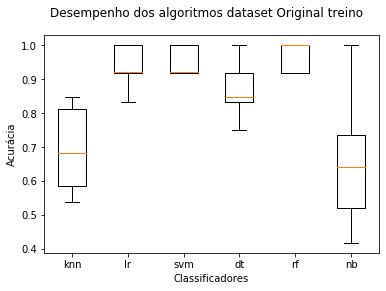

In [24]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos dataset Original treino')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')

plt.show()

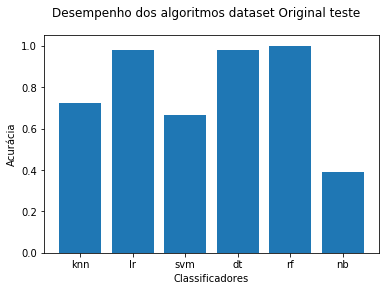

In [25]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos dataset Original teste')
plt.bar(names, acuracia_a)
ax.set_xticklabels(names)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')

plt.show()

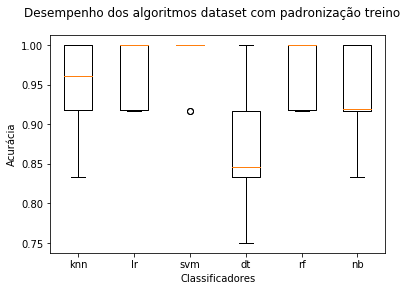

In [26]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos dataset com padronização treino')
plt.boxplot(results_st)
ax.set_xticklabels(names_st)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')

plt.show()

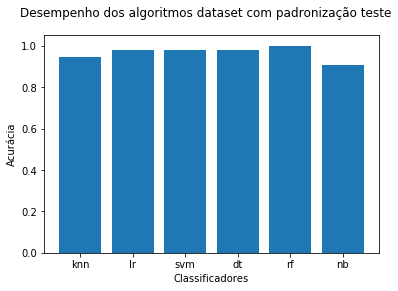

In [27]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos dataset com padronização teste')
plt.bar(names, acuracia_st)
ax.set_xticklabels(names)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')

plt.show()

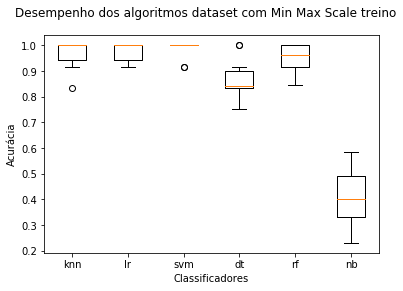

In [28]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos dataset com Min Max Scale treino')
ax.boxplot(results_mm)
ax.set_xticklabels(names_mm)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')

plt.show()

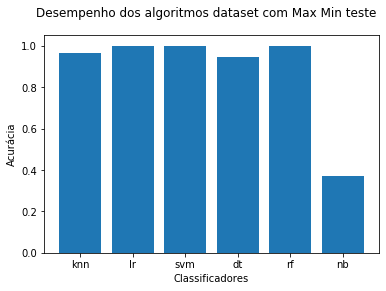

In [29]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritmos dataset com Max Min teste')
plt.bar(names, acuracia_mm)
ax.set_xticklabels(names)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')

plt.show()

### Melhor modelo foi o Random Forest tanto com normalização como com padronização dos dados, trazendo acuracia de 100% em treino e 100% em treinamento. Foi utilizado como metrica principal de avaliação a acuracia por se tratar de uma visão geral do algoritmo, mais podemos observar uma boa performance também nas demais metricas precision, recall,  f1-scorehor modelo analisado